In [1]:
import numpy as np
from matplotlib import pyplot as plt

# jit optimization for much faster calculation that allows more averaging
#
# if not installing or not wroking somehow, just comment or strip out @jit(nopython=True) decorators
# and use less symbols cnt (probably something around 1e4), or wait some minutes
from numba import jit

In [3]:
2*np.pi*38/1024

0.23316507975861744

In [29]:
@jit(nopython=True)
def constellation_order(constellation):
    orders ={
        "BPSK": 1,
        "QPSK": 2,
        "16-QAM": 4
    }
    return orders[constellation]


@jit(nopython=True)
def constellation_norm(constellation_map):
    return np.sqrt( np.mean(np.abs(constellation_map)**2) )


@jit(nopython=True)
def get_symbol_2_iq_map(constellation):
    # hardcode values for BPSK and QPSK
    if constellation == "BPSK":
        result =[
            -1+0j,
            1+0j
        ]
    elif constellation == "QPSK":
        result = [
            -1-1j,
            -1+1j,
            1-1j,
            1+1j
        ]
    elif constellation == "16-QAM":
        result = [
            -3+3j,
            -3+1j,
            -3-3j,
            -3-1j,
            -1+3j,
            -1+1j,
            -1-3j,
            -1-1j,
             3+3j,
            3+1j,
            3-3j,
            3-1j,
            1+3j,
            1+1j,
            1-3j,
            1-1j
        ]    
    else:
        print("wrong constellation:",constellation)
        raise
    
    return np.array(result)


# mapping operation
@jit(nopython=True)
def mapping(input_bits, constellation):
    symbol_2_iq_map = get_symbol_2_iq_map(constellation)
    symbol_2_iq_map = symbol_2_iq_map/constellation_norm(symbol_2_iq_map)

    # generate iq points based on chosen constellation map
    iq_points = []
    order = constellation_order(constellation)
    for i in range(len(input_bits) // order):
        
        #form bit seq of order bits length
        symbol_data = 0
        for bit_ind in range(order):
            symbol_data = (symbol_data << 1) + input_bits[i*order + bit_ind]
            
        iq_points.append(symbol_2_iq_map[symbol_data])

    return np.array(iq_points)


# demapping of iq pts to bits
@jit(nopython=True)
def demapping(input_iq_pts, constellation):
    symbol_2_iq_map = get_symbol_2_iq_map(constellation)
    symbol_2_iq_map = symbol_2_iq_map/constellation_norm(symbol_2_iq_map)
    
    out_bits = []
    order = constellation_order(constellation)
    for i in range(len(input_iq_pts)):
        symbol_data = np.argmin( np.abs(symbol_2_iq_map - input_iq_pts[i]) )
        
        for bit_ind in range(order):
            out_bits.append((symbol_data >> (order-1-bit_ind))&1)

    return np.array(out_bits)


# returns array of iq pts that are the closest constellation points to input_iq_points
@jit(nopython=True)
def closest_constellation_pts(input_iq_pts, constellation):
    symbol_2_iq_map = get_symbol_2_iq_map(constellation)
    symbol_2_iq_map = symbol_2_iq_map/constellation_norm(symbol_2_iq_map)
    
    out_pts = []
    order = constellation_order(constellation)
    for i in range(len(input_iq_pts)):
        out_pts.append(symbol_2_iq_map[np.argmin( np.abs(symbol_2_iq_map - input_iq_pts[i]) )])
        
    return np.array(out_pts)


In [30]:
# just a test for map demap operation
test_bits = np.random.randint(0, 2, int(1e3), dtype=int)
iq = mapping(test_bits, "16-QAM")
demap_bits = demapping(iq, "16-QAM")

print("max bit error: {}, should be 0".format(max(np.abs(test_bits-demap_bits))))

max bit error: 0, should be 0


In [31]:
@jit(nopython=True)
def agwn_cmplx(Ps, snr, sz):
    Pn = Ps / (10 ** (snr / 10))
    return np.random.normal(0, np.sqrt(Pn/2), sz) + 1j * np.random.normal(0, np.sqrt(Pn/2), sz)

In [32]:
@jit(nopython=True)
def MER(iq_noisy, constellation):
    # find closest constellation points
    iq_closest = closest_constellation_pts(iq_noisy, constellation)
    
    # error from closest
    err = iq_noisy - iq_closest
    
    # signal and error energies (we could use powers, but doesn't matter)
    Es = (iq_closest @ iq_closest.conj()).real
    Ee = (err @ err.conj()).real
    
    # mer in dB
    return 10*np.log10(Es/Ee)
    

In [33]:
rand_bits = np.random.randint(0, 2, int(1e7), dtype=int)

# test configuration
# symbols count to average on
symbols_cnt = int(1e5)
# snrs to test on
snrs = np.arange(-50, 20, 1)
#constellations to test
constellations = ["BPSK", "QPSK", "16-QAM"]


mers = {}
for constellation in constellations:
    # number of bits needed for this constellation
    bits_cnt = symbols_cnt*constellation_order(constellation)
    
    # generate random iq sequence of symbols_cnt length
    iq = mapping(rand_bits[:bits_cnt], constellation)
    Ps = ((iq @ iq.conj()).real)/len(iq) # almost 1 anyway

    mers[constellation] = []
    for snr in snrs:
        # add noise
        iq_noisy = iq + agwn_cmplx(Ps, snr, len(iq))
        
        # calculate MER and save results
        mers[constellation].append(MER(iq_noisy, constellation))


<IPython.core.display.Javascript object>


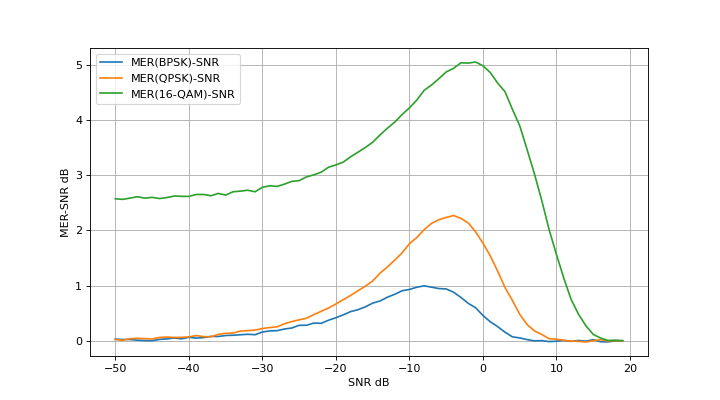

Text(0, 0.5, 'MER-SNR dB')

In [37]:
%matplotlib notebook
plt.figure(figsize=(9, 5))

for constellation in constellations:
    plt.plot(snrs, mers[constellation]-snrs)

plt.grid(True)
plt.legend(["MER({})-SNR".format(constellation) for constellation in constellations])
plt.xlabel("SNR dB")
plt.ylabel("MER-SNR dB")

# same curve on BPSK as integral of distribution

In [35]:
from scipy import integrate
from scipy import stats

mers_theor = []
for snr in snrs:
    Pn = (10**(-snr/10))
    Pn_add, abs_err = integrate.quad(
        lambda x: 4*(1-x)*stats.norm.pdf(x, loc=0, scale=np.sqrt(Pn/2)), 
        1, np.inf,
        epsabs=1e-18
    )
    Pn_mer = Pn/2 + Pn/2 + Pn_add
    mers_theor.append(10*np.log10(1/Pn_mer))


<IPython.core.display.Javascript object>


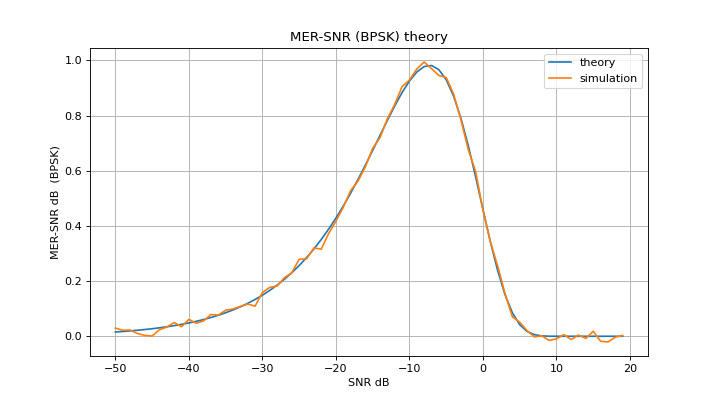

Text(0.5, 1.0, 'MER-SNR (BPSK) theory')

In [36]:
%matplotlib notebook
plt.figure(figsize=(9, 5))

plt.plot(snrs, mers_theor - snrs)
plt.plot(snrs, mers["BPSK"] - snrs)
plt.grid(True)
plt.legend(["theory", "simulation"])
plt.xlabel("SNR dB")
plt.ylabel("MER-SNR dB  (BPSK)")
plt.title("MER-SNR (BPSK) theory")